In this notebook, we will predict the likelihood of a heart attack.

# Task

## 1.
Calculate Permutation-based Variable Importance for the selected model.

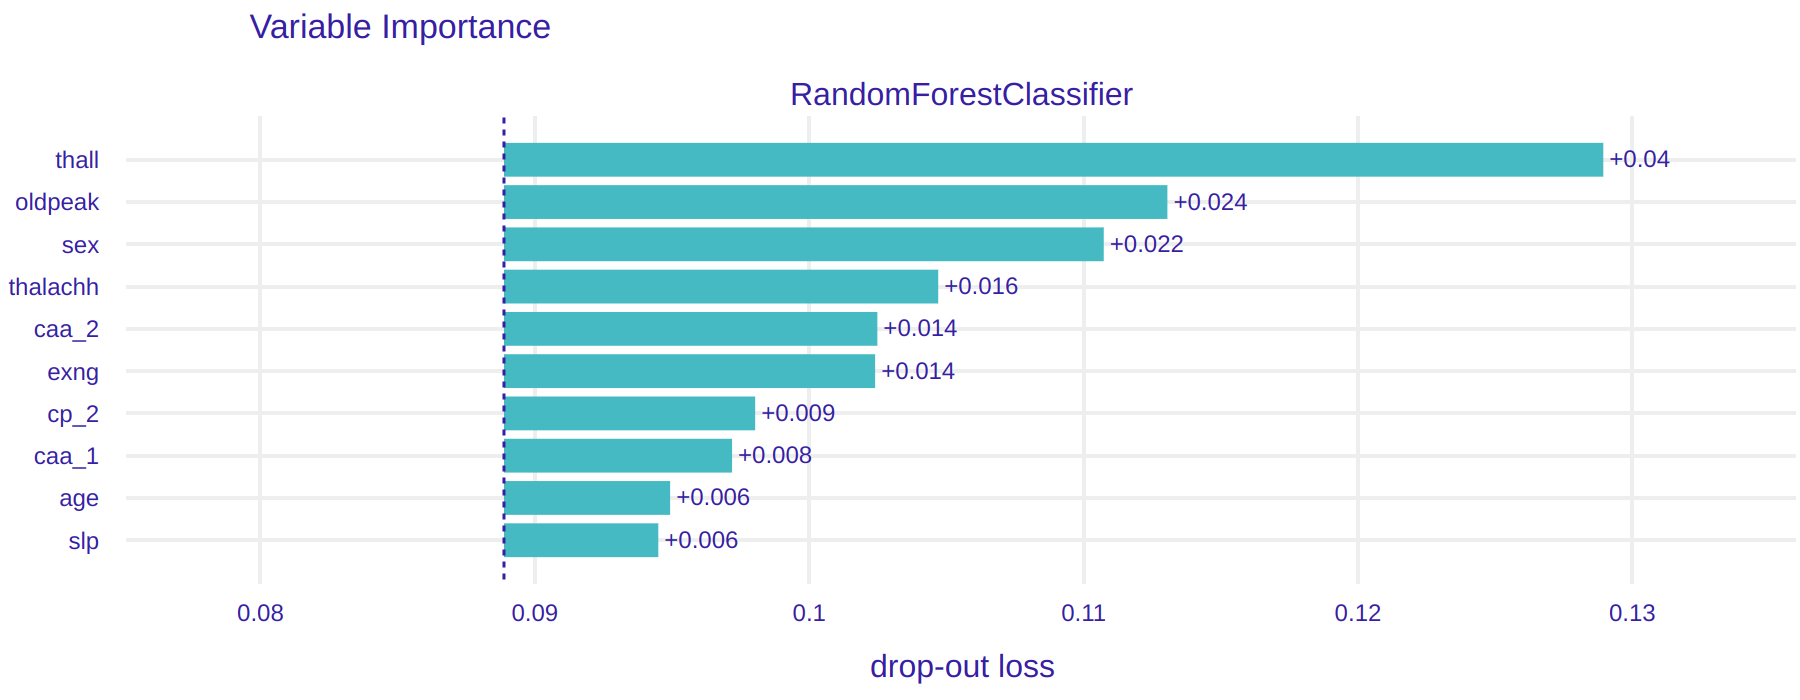

As we can see, thall is the most important feature. Then we have oldpeak and sex.

## 2.
Train three more candidate models (different variable transformations, different model architectures, hyperparameters) and compare their rankings of important features using PVI. What are the differences? Why?

**Shallow Random Forest Classifier with max depth equal 5**

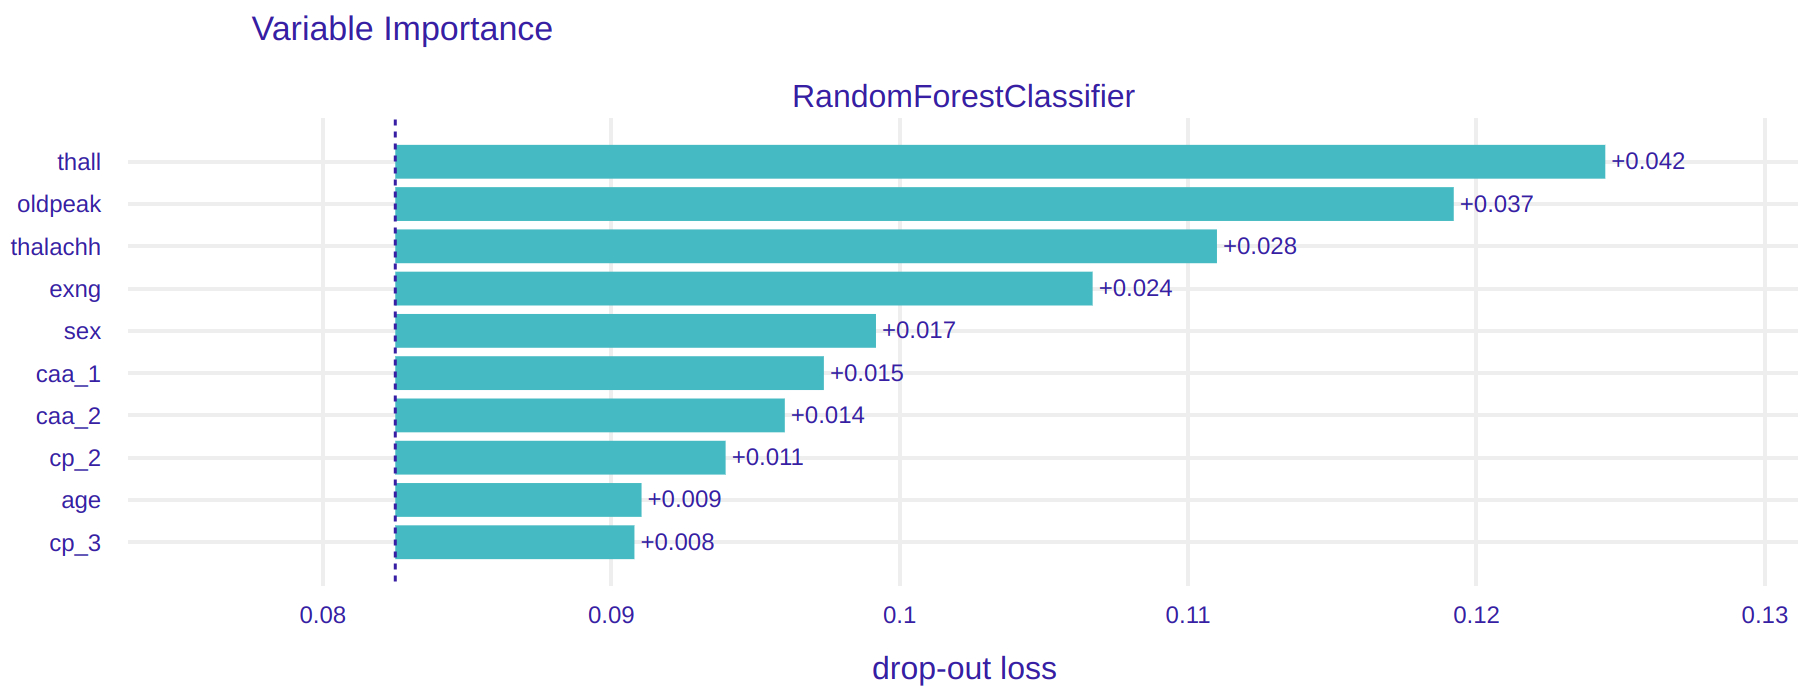

Thall and oldpeak are still the most important features, but the order of importance of the rest has changed. Probably the reason for this is that if the tree is shallow, the classifier is not able to generalize the information about the data, so it focuses on some specific features.

**Random Forest Classifier without bootstrap**

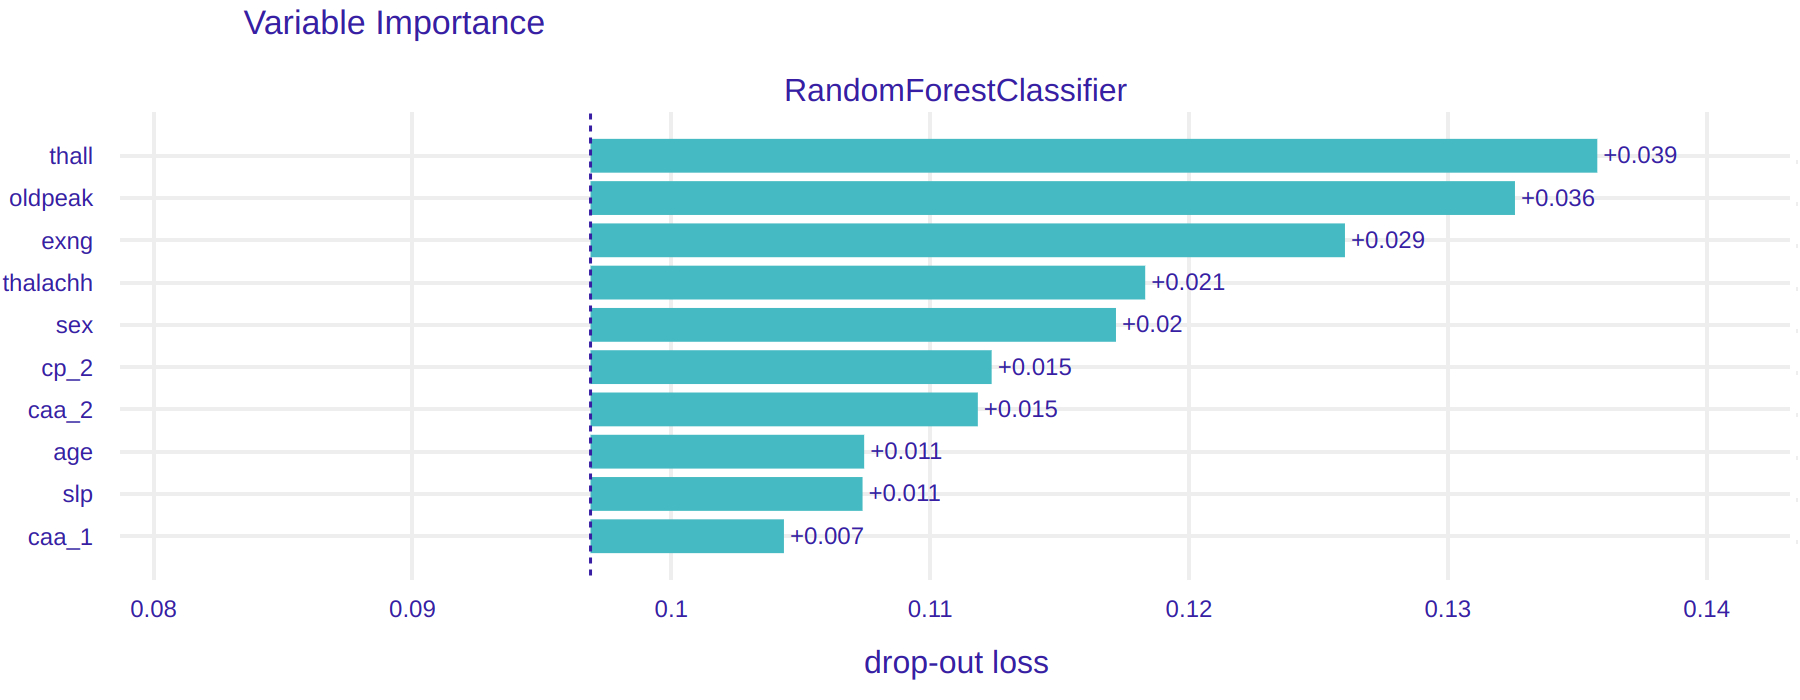

Here the order of variable importance has changed again. We have no bootstrap, so the observations are sampled without replacement and each tree is trained on all of the observations. Hence the dependency of the samples in trees is high and the variance is also high. This is why the importance of features is not close to general results obtained for the model with bootstrap.

**Logistic regression**

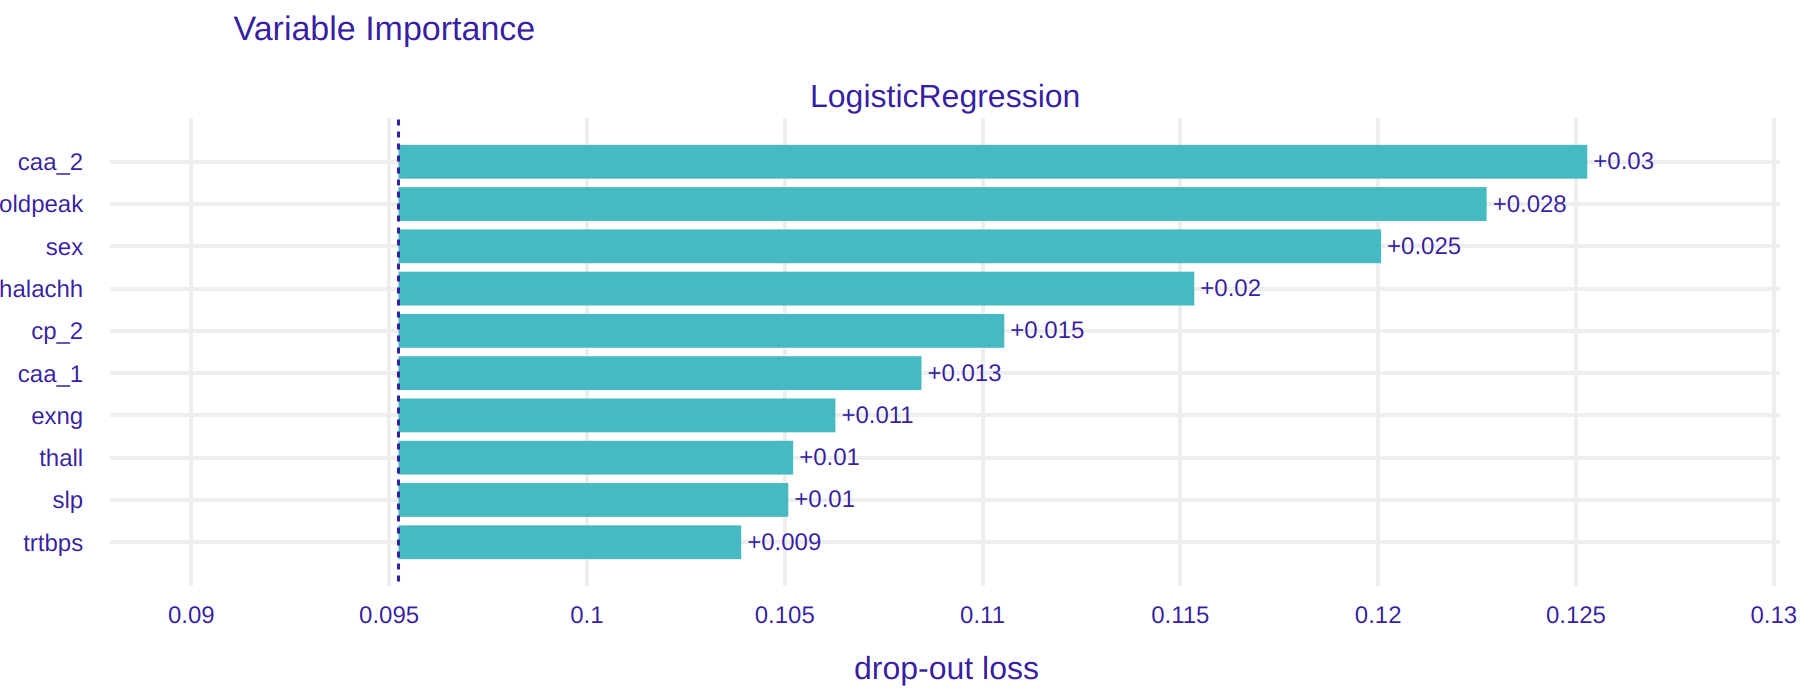

The results for logistic regression differ completely - not only in the order, but also in the value of feature importance. These two architectures have nothing in common, so it is expectable that the variable importance will be different for them.

## 3.
For the tree-based model from (1), compare PVI with:

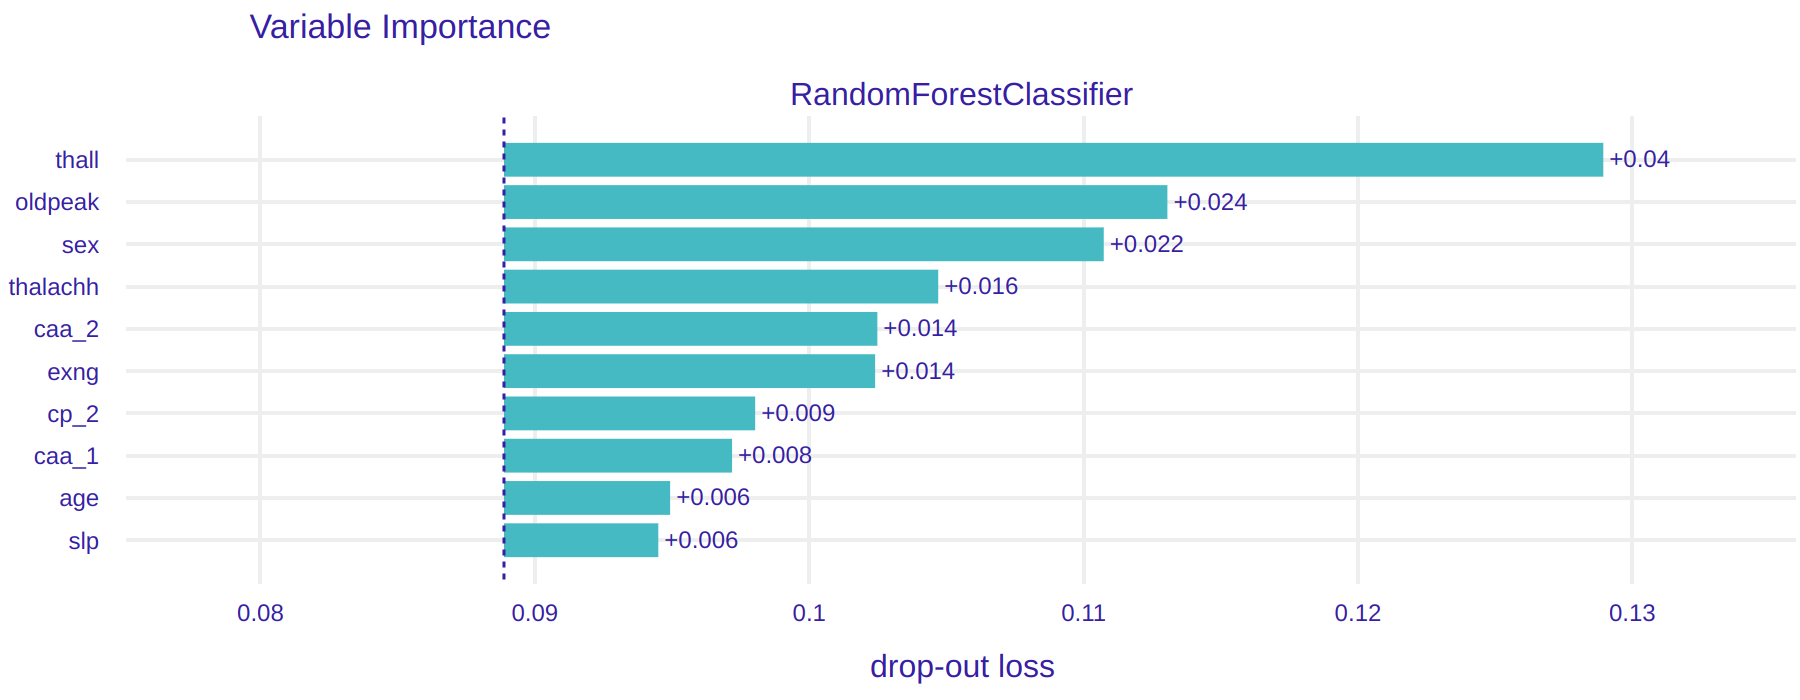

A) the traditional feature importance measures for trees: Gini impurity etc.; what is implemented in a given library: see e.g. the feature_importances_ attribute in xgboost and sklearn.

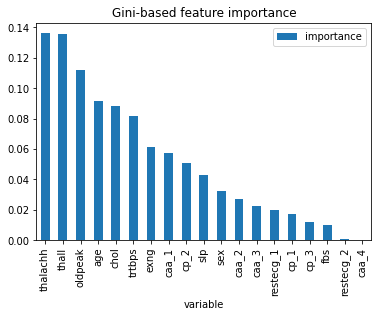

The importance is completely different. Suddenly thalachh is the most important feature and sex is no longer important.

B) [in Python] SHAP variable importance based on the TreeSHAP algorithm available in the shap package.

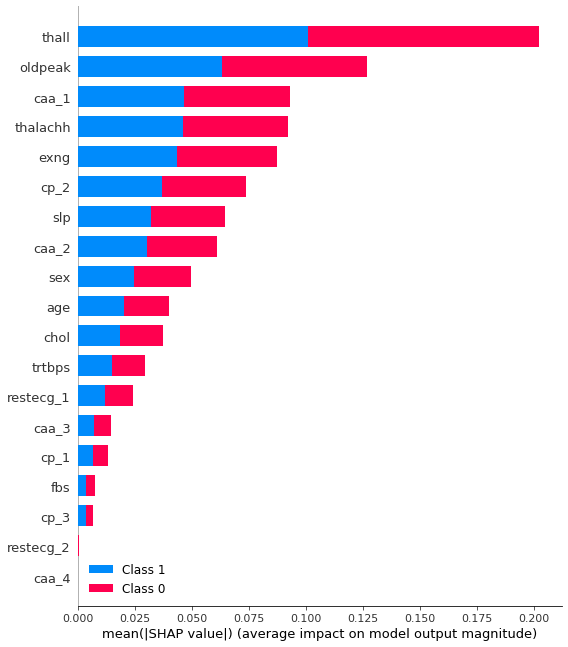

Here the sex is as unimportant as the age, which did not take place for PVI. Also the caa became more important.

In the end, we can conclude that each method gives us different results.

# Appendix

In [31]:
#@title Imports
import dalex as dx

import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

## Data download

Please, write your Kaggle username and key below.

In [7]:
import json 
import os
from pathlib import Path

# your api key
api_key = {
'username':"username" ,  # Edit this line.
'key':"key"}  # Edit this line.

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object 
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)  

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
filename = 'heart.csv'
api.dataset_download_file('rashikrahmanpritom/heart-attack-analysis-prediction-dataset', file_name=filename, path='./')

In [9]:
df = pd.read_csv(filename).dropna()
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


## 0.

In [12]:
X = df.drop(columns='output')
X = pd.get_dummies(X, columns=['caa', 'cp', 'restecg'], drop_first=True)
y = df.output

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)

In [ ]:
shallow_rfc_model = RandomForestClassifier(max_depth=5)
shallow_rfc_model.fit(X_train, y_train)

In [ ]:
no_bootstrap_rfc_model = RandomForestClassifier(bootstrap=False)
no_bootstrap_rfc_model.fit(X_train, y_train)

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

## 1.

In [ ]:
rfc_explainer = dx.Explainer(rfc_model, X_test, y_test, verbose=False)
rfc_explainer.model_parts(random_state=0).plot(show=False)

## 2.

In [ ]:
shallow_rfc_explainer = dx.Explainer(shallow_rfc_model, X_test, y_test, verbose=False)
shallow_rfc_explainer.model_parts(random_state=0).plot(show=False)

In [ ]:
no_bootstrap_rfc_explainer = dx.Explainer(no_bootstrap_rfc_model, X_test, y_test, verbose=False)
no_bootstrap_rfc_explainer.model_parts(random_state=0).plot(show=False)

In [ ]:
lr_explainer = dx.Explainer(lr_model, X_test, y_test, verbose=False)
lr_explainer.model_parts(random_state=0).plot(show=False)

## 3.

In [ ]:
df1 = pd.DataFrame({"variable": X_train.columns, "importance": rfc_model.feature_importances_})
df1 = df1.sort_values("importance", ascending=False)
df1.plot.bar(x="variable", y="importance")
plt.title("Gini-based feature importance")
plt.show()

In [ ]:
shap_vi = rfc_explainer.model_parts(type="shap_wrapper", shap_explainer_type="TreeExplainer", check_additivity=False)
shap_vi.plot()